# Case Study 2: K-Nearest Neighbors and RTLS

KJ Price, Amber Whelpley, Festus Asare Yeboah

Real-time Location Systems (RTLS) are used in the prediction of device locations primarily in indoor settings. The dataset used in this case study consists of 151,392 lines, 5,312 of which are comments. This leaves us overall with 146,080 lines of data. Each line includes data related to the scanning device in addition to data related to all devices responding to the scanning device in question.

Information about the scanning device includes:
- time: the timestamp, representing the number of milliseconds since 1/1/1970 UTC     
- scanMac: the MAC address of the scanning device     
- posX, posY, & posZ: the X, Y, and Z physical coordinates, respectively, of the scanning device     
- orientation: the orientation in degrees of the scanning device     

The remaining information on each line includes the following information collected about each responding device:     
- mac: the MAC address of the responding device     
- signal: the signal strength of the responding device in dBm     
- channel: the channel frequency of the responding device     
- type: the mode of operation, designated as '3' for an access point and '1' for adhoc mode     

### Organizing the Data

Although there were 146,080 scanning devices, there are over one million responding devices listed in the data set. In order to add structure to the data for our analysis, these must be separated.

To accomplish this, the comments are first removed and then matrices are created for each responding device listed for every scanning device in the *offline* dataset. These matrices are then merged into a data frame consisting of 10 columns and 1,181,628 rows. An example of the matrix created for the first row of data, which included 11 responding devices, is shown below.

In [13]:
mat

1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e0:4b,-78,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e2:10,-87,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:64:fb:68:52:e6,-88,2447000000,1
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:00:42:55:31:00,-84,2457000000,1


### Cleaning the Data

For proper analysis, we must convert several of the variables into numeric types that can be compared and correlated properly. 

Ad-hoc devices will not be used in this analysis, so all devices with a type of '1' are removed from the data frame. As a result, all remaining observations have a type of '3' and the entire variable can be removed as well. The data frame now consists of 9 columns and 978,443 observations.

In [25]:
head(offline)

time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56,2427000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:81,-65,2422000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,3


In [26]:
# Remove things that are not type=3 and then remove type
offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

[1] 978443      9

# Exploring Orientation

Through review of the current data frame, it appears that there are 203 unique values for the orientation variable. Based upon 45 degree increments between 0 and 359, only 8 unique orientations were expected.

In order to examine this discrepancy, the values of orientation were plotted in Fig.1 so that the distribution could be examined visually. The plot shows that although there are 203 values for orientation, they are all clustered around the values that were originally expected. Based on this information, it seems reasonable to assume that these slight differences are due to the scanning devices being handheld and not orientated in the precise direction.

To account for this, the orientation value for each row is reassigned to its closest expected value. 

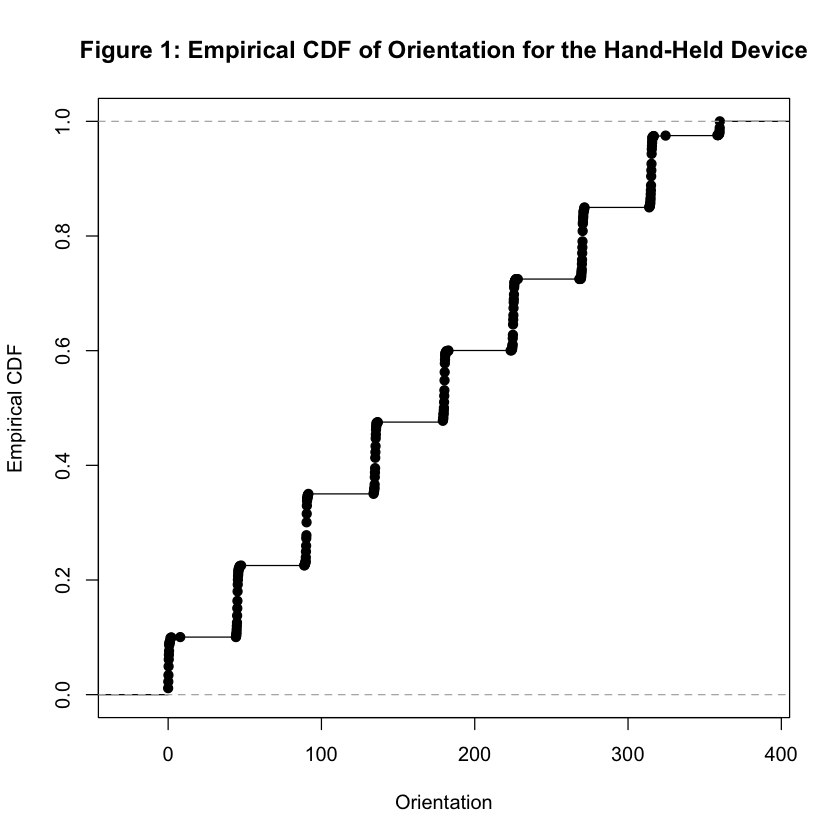

In [56]:
# Why aren't there just 8 orientations? What does the distribution actually look like?
# From the following, we can tell that we are using both 0 and 360 degrees (these should be combined)
# Also, there seems to be too much precision here, meaning it seems that we have a bunch of values like 0.12 (which should be just 0)

plot(ecdf(offline$orientation),main="Figure 1: Empirical CDF of Orientation for the Hand-Held Device",
        xlab="Orientation", ylab="Empirical CDF")

A boxplot (Fig. 2) is used to verify that the rounding and reassignment of the orientation variable occurred as expected. The plot shows the 8 evenly spaced angles. The observations in the top left of the graph are those that are closest to 360 degrees. Because 360 degrees is the same as 0, these observations were assigned 0.

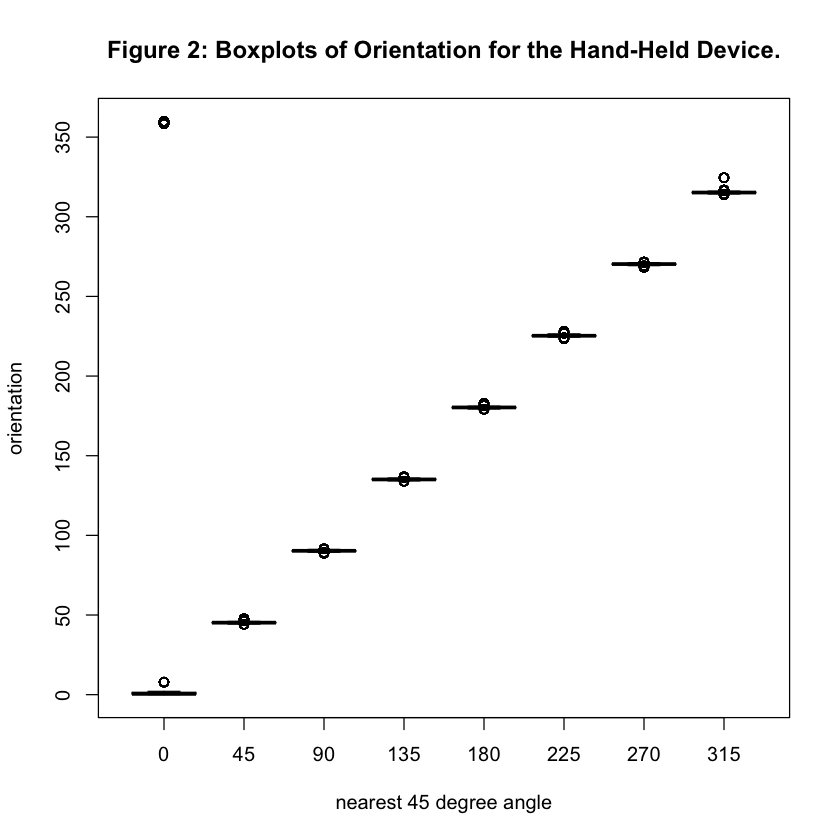

In [57]:
with(offline, boxplot(orientation ~ angle, main = "Figure 2: Boxplots of Orientation for the Hand-Held Device.",
                      xlab = "nearest 45 degree angle",
                      ylab="orientation"))

## Exploring MAC Addresses

The experiment described 6 MAC addresses on the network, yet 12 MAC addresses were identified within the data frame. Viewing a table of the occurrences of each of these 12 addresses shows that the counts of the first and the last two MAC addresses combined constitute less than 0.01% of the total number of observations. In addition, the third and fifth addresses have significantly fewer occurences as well. These five addresses were removed from the dataset, leaving the seven addresses that occurred the most frequently.

In [38]:
# Get a count at how many times each MAC shows up
table(offline$mac)


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

A comparison of the remaining seven MAC addresses with the channel variable demonstrates that each address corresponds to only one specific channel. Using both variables for this analysis will not result in any additional statistical significance, and may even lead to unwanted correlation, so the channel variable is removed.

In [41]:
# Look at combination of mac/channel
macChannel = with(offline, table(mac, channel))
macChannel

                   channel
mac                 2412000000 2422000000 2427000000 2432000000 2437000000
  00:0f:a3:39:dd:cd     145619          0          0          0          0
  00:0f:a3:39:e1:c0          0          0          0          0          0
  00:14:bf:3b:c7:c6          0          0          0     126529          0
  00:14:bf:b1:97:81          0     120339          0          0          0
  00:14:bf:b1:97:8a          0          0          0          0     132962
  00:14:bf:b1:97:8d          0          0          0          0          0
  00:14:bf:b1:97:90          0          0     122315          0          0
                   channel
mac                 2442000000 2462000000
  00:0f:a3:39:dd:cd          0          0
  00:0f:a3:39:e1:c0          0     145862
  00:14:bf:3b:c7:c6          0          0
  00:14:bf:b1:97:81          0          0
  00:14:bf:b1:97:8a          0          0
  00:14:bf:b1:97:8d     121325          0
  00:14:bf:b1:97:90          0          0

## Exploring Location Combinations

The experiment describes 166 individual positions for recorded measurements, so the position values are also examined to determine whether the data appears consistent.

Initially, it appears that there are 476 total combinations of posX and posY, almost three times the expected value; however, further examination shows that 310 of these values are null. Removing these values leaves us with 166 combinations of posX and posY, exactly the number expected originally.

A visualization of the number of occurrences at each expected location (Fig. 3) shows that the number of measurements for each is approximately 5,500. Although the measurements are not exactly equal, they are close enough to be comfortable that the position variables will not bias our analysis.

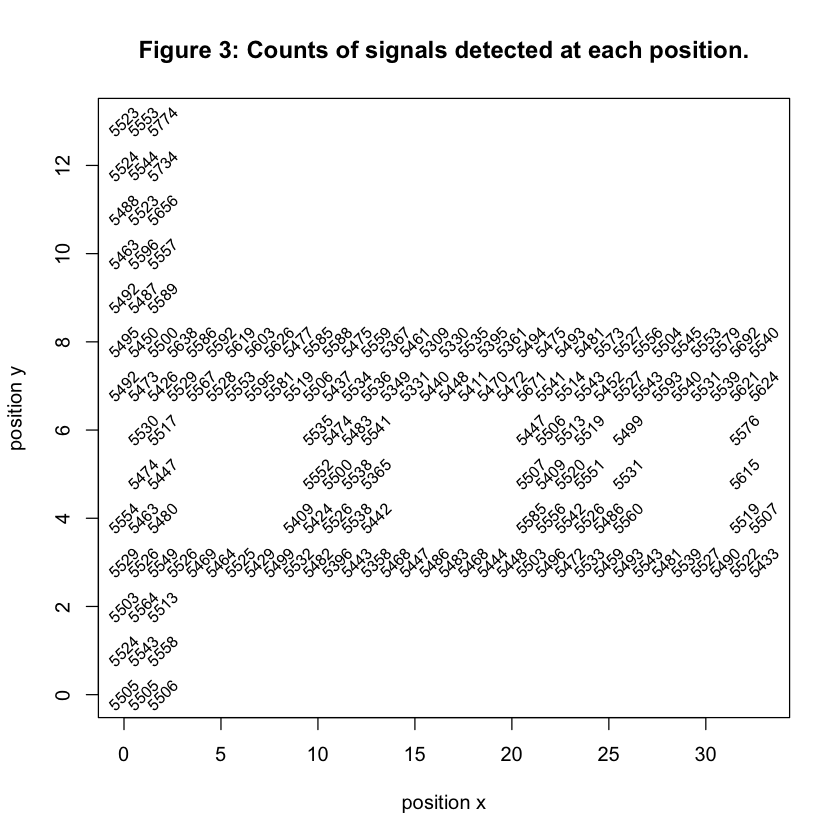

In [52]:
# Visualize the locations with tgeir counts
locCounts = t(locCounts)
plot(locCounts, main = "Figure 3: Counts of signals detected at each position.", type = "n", xlab = "position x", ylab = "position y",)
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

## Signal Strength Analysis 

In the analysis that follows we dive deep into the response variable, signal strength to answer the following questions:
*  What is the distribution of the repeated measure at each location and orientation?
*  How can we characterize the relationship between signal strength and distance from the device to access point?

To examine the response variable, signal strength, we must first determine whether the signal strength remains consistent across various distances and with varying orientations. The distribution of signal strengths at various location is shown in Fig. 4. The figure shows that the mean signal strength can vary significantly for varying combinations of location and orientation. It can also be seen on the graph that values for the signal strength variable are all negative. The closer a signal strength is to zero, the stronger it is.

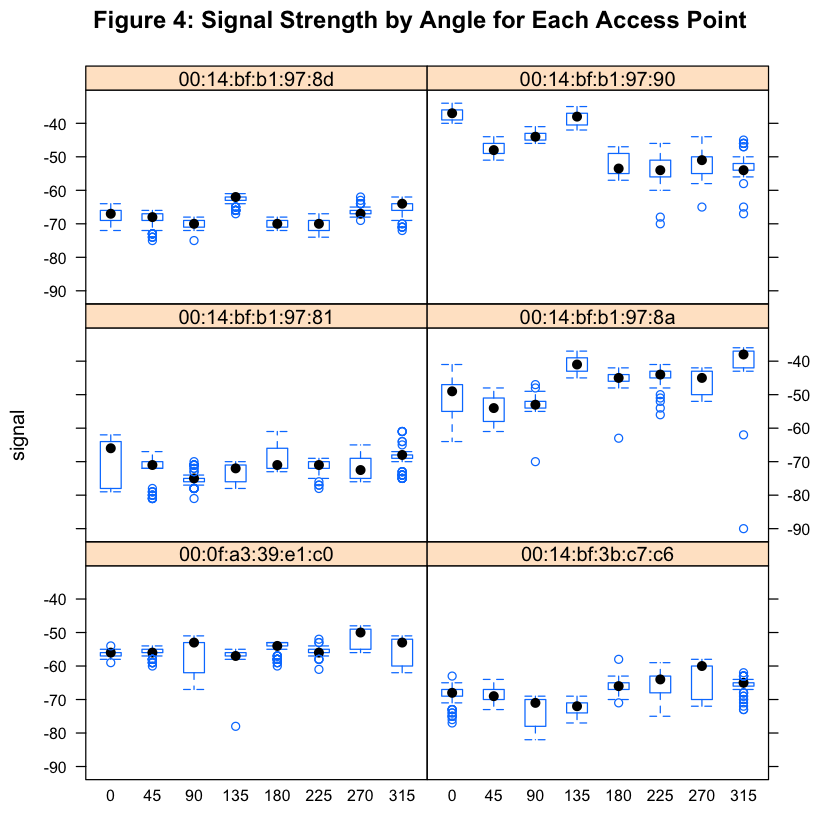

In [4]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, main = "Figure 4: Signal Strength by Angle for Each Access Point",data = offline,
subset = posX == 2 & posY == 12
& mac != "00:0f:a3:39:dd:cd",
layout = c(2,3))

Fig. 5 shows a comparison of the distributions of signal strength for the 8 different angles
and 6 MAC addresses at the central location of x = 24 and y = 4.

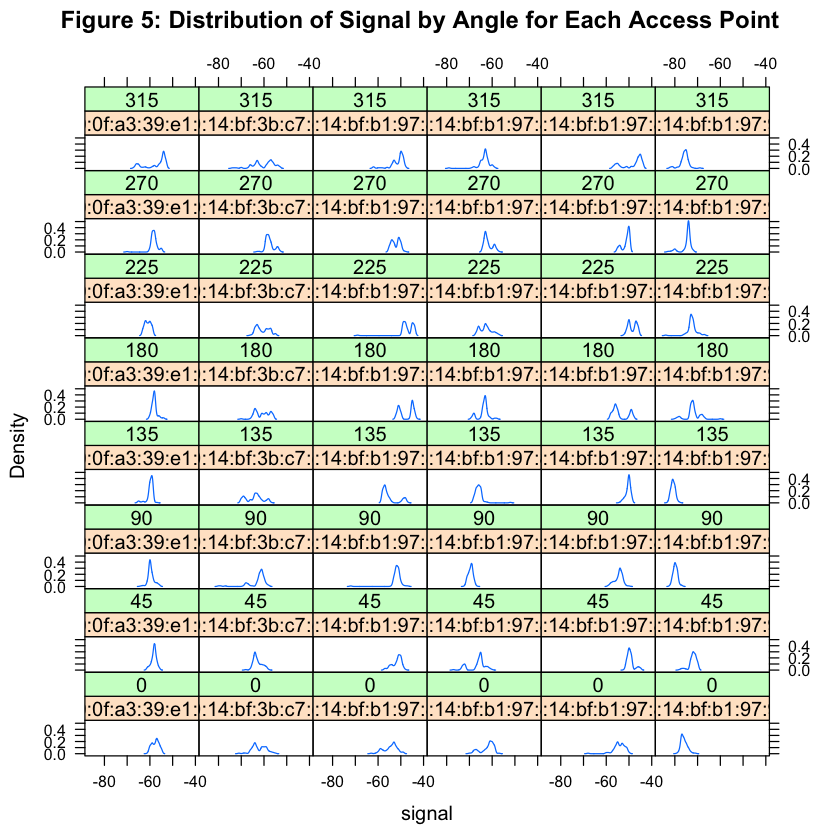

In [16]:
densityplot( ~ signal | mac + factor(angle), main = "Figure 5: Distribution of Signal by Angle for Each Access Point",data = offline,
subset = posX == 24 & posY == 4 &
mac != "00:0f:a3:39:dd:cd",
bw = 0.5, plot.points = FALSE)

Examining the distribution of signal strength for all 166 locations, 8 angles and 6 acess points using summary statitics (Fig. 6, 7) allows us to see that the median and mean are not substantially different, thus is not significantly skewed.

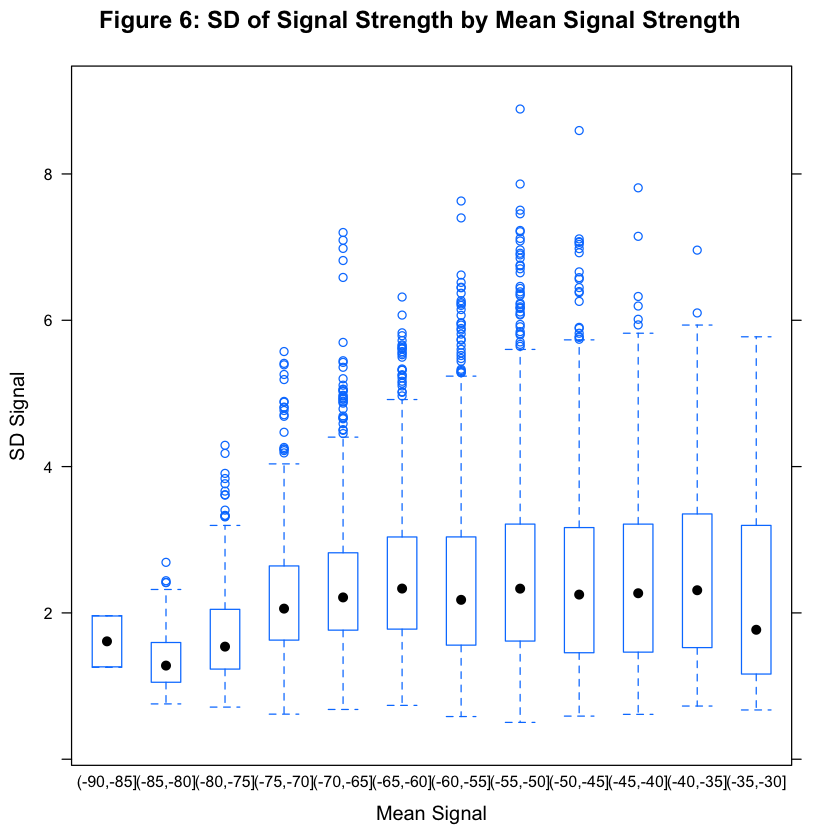

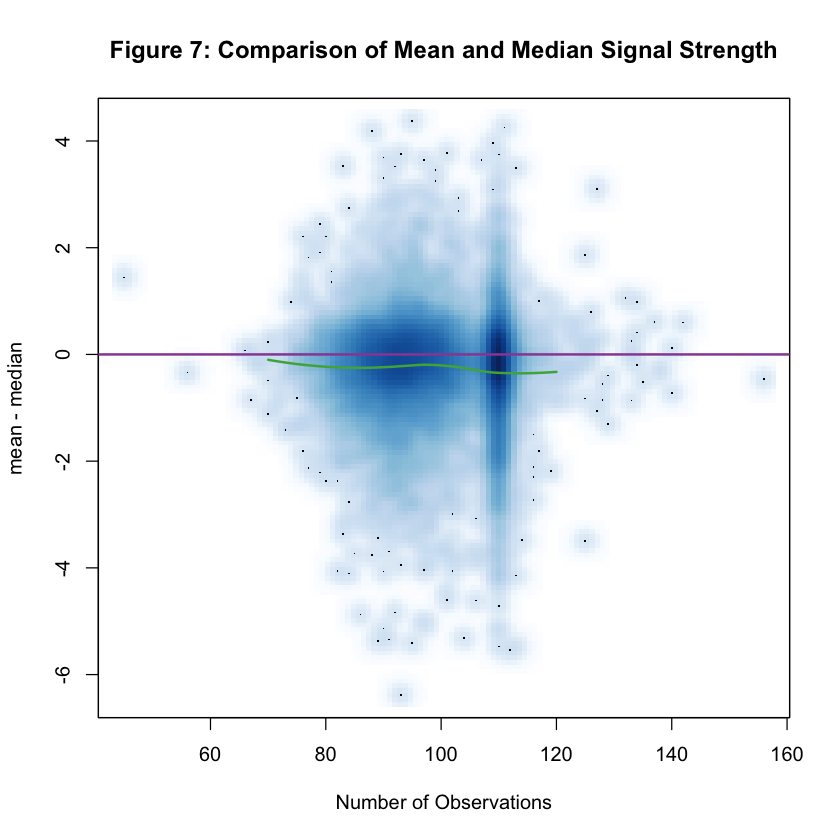

In [18]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
data = offlineSummary,
subset = mac != "00:0f:a3:39:dd:cd",main = "Figure 6: SD of Signal Strength by Mean Signal Strength",
xlab = "Mean Signal", ylab = "SD Signal")

with(offlineSummary,
smoothScatter((avgSignal - medSignal) ~ num,
main = "Figure 7: Comparison of Mean and Median Signal Strength",
xlab = "Number of Observations",
ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)


lo.obj =
with(offlineSummary,
loess(diff ~ num,
data = data.frame(diff = (avgSignal - medSignal),
num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)


# Signal Strength and Distances

The heat map in Fig. 8 demonstrates the areas on the floor plan where signal strengths are higher by comparing specific MAC addresses and orientations. The darker read area on this map indicates the access point position, and shows that the strength of signals decreases as the distance between the source and the access point increases.

Using this knowledge, other combinations of orientation and addresses are examined in Fig. 9. These additional heat maps show continued evidence of the signal strength decreasing with distance.

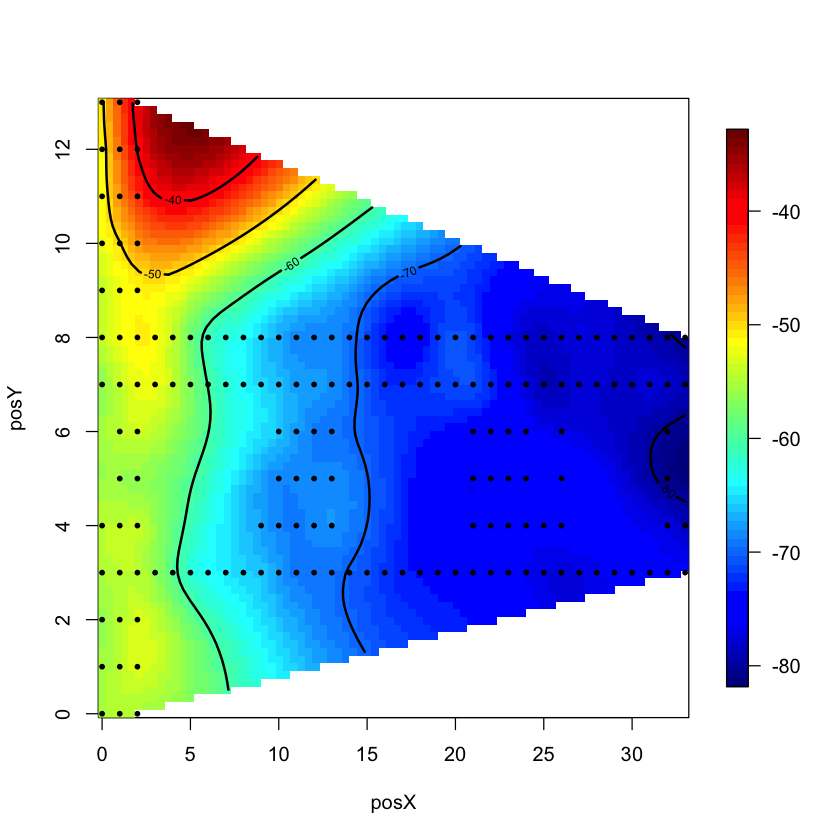

In [11]:
plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

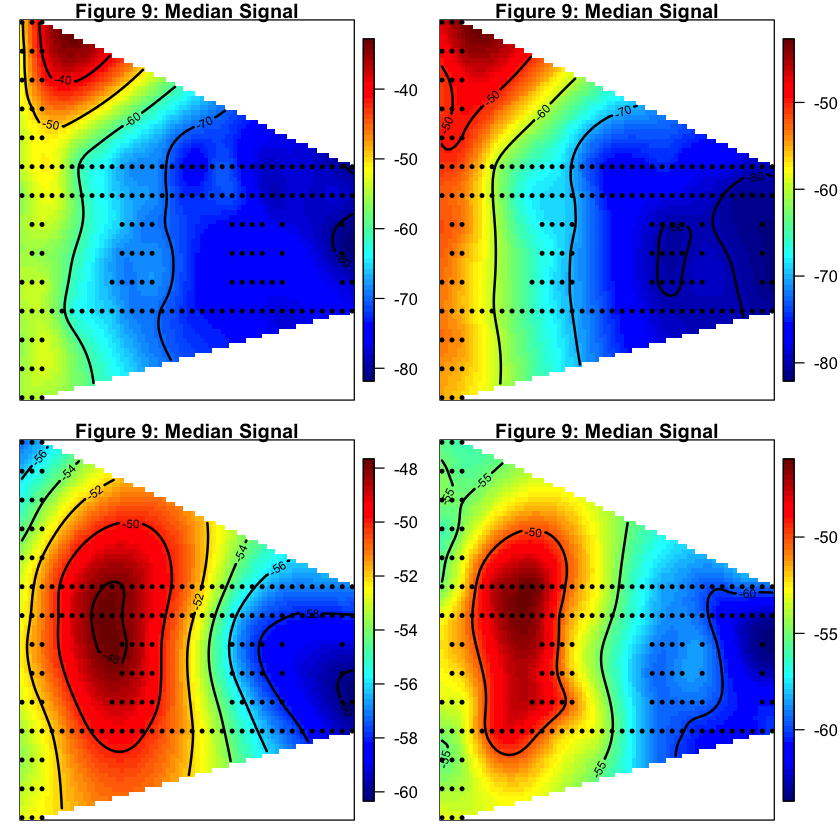

In [26]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", main = "Figure 9: Median Signal", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))


mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ],
angle = rep(c(0, 135), 2),
data = list(data = offlineSummary))

# KNN Analysis

In the analysis provided by the authors, Nolan and Lang, we learn that there are six individual locations for access points but apparently seven different MAC addresses (all with their own data). So, there are two different devices (with their own MAC addresses) occupying the same location. These devices have the MAC addresses` 00:0f:a3:39:e1:c0` and `00:0f:a3:39:dd:cd`. We are told that they decided to keep the access point having the MAC address `00:0f:a3:39:e1:c0` and drop the other.

We are given the assignment of determining which combination of MAC addresses provides us with an optimal result. Should we keep one, or the other, or both? Here are the results that we found:

 - Keeping the MAC address that they decided to keep (`00:0f:a3:39:e1:c0`), we get an error of **20,561**
 - Using the MAC address that they decided to drop (`00:0f:a3:39:dd:cd`), we get an error of **17,582**
 - Using all of the MAC addresses available, we get an error of **8,722**.

Indeed, it is better to use the MAC address which they decided to drop. Furthermore, if we had the option, then it is clearly better to use both MAC addresses.

# References

D. Lang and D. Nolan, Data Science in R: A Case Studies Approach to Computation Reasoning and Problem Solving. New York, New York: CRC Press.

# Programming Code Appendix

## ----------------------------------------------------


### first we download the data

In [6]:
source('setup.r')

[1] "../data/offline.final.trace.txt  already exists"
[1] "../data/online.final.trace.txt  already exists"


### Load the data

In [89]:
DATA_FRAME_SOURCE = '../data/offline.final.trace.csv'
TEXT_FILE_SOURCE = '../data/offline.final.trace.txt'

OFFLINE_SOURCE_CSV = '../data/offline.final.trace.csv'
OFFLINE_SOURCE = '../data/offline.final.trace.txt'
ONLINE_SOURCE = '../data/online.final.trace.txt'

ALL_MACS = c('00:0f:a3:39:dd:cd', '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90')

# remove 00:0f:a3:39:dd:cd
ORIGINAL_MACS = c('00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90')

NEXT_MACS = c('00:0f:a3:39:dd:cd', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90')


In [8]:
txt = readLines(TEXT_FILE_SOURCE)

### Get basic info about data

In [9]:
# The number of comments
sum(substr(txt, 1, 1) == "#")

[1] 5312

In [10]:
# The "length" of the document
length(txt)

[1] 151392

In [11]:
length(txt) - sum(substr(txt,1,1)=="#")


[1] 146080

In [12]:
strsplit(txt[4], ";")[[1]]

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

In [13]:
unlist(lapply(strsplit(txt[4], ";")[[1]],
              function(x)
                sapply(strsplit(x, "=")[[1]], strsplit, ",")))

t       1139643118358                  id   00:02:2D:21:0F:33 
                "t"     "1139643118358"                "id" "00:02:2D:21:0F:33" 
                pos        0.0,0.0,0.01        0.0,0.0,0.02        0.0,0.0,0.03 
              "pos"               "0.0"               "0.0"               "0.0" 
             degree                 0.0   00:14:bf:b1:97:8a   -38,2437000000,31 
           "degree"               "0.0" "00:14:bf:b1:97:8a"               "-38" 
  -38,2437000000,32   -38,2437000000,33   00:14:bf:b1:97:90   -56,2427000000,31 
       "2437000000"                 "3" "00:14:bf:b1:97:90"               "-56" 
  -56,2427000000,32   -56,2427000000,33   00:0f:a3:39:e1:c0   -53,2462000000,31 
       "2427000000"                 "3" "00:0f:a3:39:e1:c0"               "-53" 
  -53,2462000000,32   -53,2462000000,33   00:14:bf:b1:97:8d   -65,2442000000,31 
       "2462000000"                 "3" "00:14:bf:b1:97:8d"               "-65" 
  -65,2442000000,32   -65,2442000000,33   00:14:bf:b1:97:81   -65,2422000000,31 
       "2442000000"                 "3" "00:14:bf:b1:97:81"               "-65" 
  -65,2422000000,32   -65,2422000000,33   00:14:bf:3b:c7:c6   -66,2432000000,31 
       "2422000000"                 "3" "00:14:bf:3b:c7:c6"               "-66" 
  -66,2432000000,32   -66,2432000000,33   00:0f:a3:39:dd:cd   -75,2412000000,31 
       "2432000000"                 "3" "00:0f:a3:39:dd:cd"               "-75" 
  -75,2412000000,32   -75,2412000000,33   00:0f:a3:39:e0:4b   -78,2462000000,31 
       "2412000000"                 "3" "00:0f:a3:39:e0:4b"               "-78" 
  -78,2462000000,32   -78,2462000000,33   00:0f:a3:39:e2:10   -87,2437000000,31 
       "2462000000"                 "3" "00:0f:a3:39:e2:10"               "-87" 
  -87,2437000000,32   -87,2437000000,33   02:64:fb:68:52:e6   -88,2447000000,11 
       "2437000000"                 "3" "02:64:fb:68:52:e6"               "-88" 
  -88,2447000000,12   -88,2447000000,13   02:00:42:55:31:00   -84,2457000000,11 
       "2447000000"                 "1" "02:00:42:55:31:00"               "-84" 
  -84,2457000000,12   -84,2457000000,13 
       "2457000000"                 "1"

In [14]:
tokens = strsplit(txt[4], "[;=,]")[[1]]

In [15]:
tokens

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"               "00:14:bf:b1:97:8a" "-38"              
[13] "2437000000"        "3"                 "00:14:bf:b1:97:90"
[16] "-56"               "2427000000"        "3"                
[19] "00:0f:a3:39:e1:c0" "-53"               "2462000000"       
[22] "3"                 "00:14:bf:b1:97:8d" "-65"              
[25] "2442000000"        "3"                 "00:14:bf:b1:97:81"
[28] "-65"               "2422000000"        "3"                
[31] "00:14:bf:3b:c7:c6" "-66"               "2432000000"       
[34] "3"                 "00:0f:a3:39:dd:cd" "-75"              
[37] "2412000000"        "3"                 "00:0f:a3:39:e0:4b"
[40] "-78"               "2462000000"        "3"                
[43] "00:0f:a3:39:e2:10" "-87"               "2437000000"       
[46] "3"                 "02:64:fb:68:52:e6" "-88"              
[49] "2447000000"        "1"                 "02:00:42:55:31:00"
[52] "-84"               "2457000000"        "1"

### Create a matrix for data (just first row)

In [16]:
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)

In [17]:
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
                   ncol = 6, byrow = TRUE),
tmp)

In [18]:
dim(mat)

[1] 11 10

In [19]:
mat

1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,2412000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e0:4b,-78,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e2:10,-87,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:64:fb:68:52:e6,-88,2447000000,1
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,02:00:42:55:31:00,-84,2457000000,1


In [20]:
processLine =
function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
ncol = 6, byrow = TRUE), tmp)
}

In [21]:
# TODO: Use all rows (not just 20th)
#tmp = lapply(txt[4:20], processLine)

lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [22]:
offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

[1] 1181628      10

### To fix the above error, let's not continue with processing if we do not have any tokens with a row

In [23]:
processLine = function(x)
{
    tokens = strsplit(x, "[;=,]")[[1]]
    if (length(tokens) == 10)
      return(NULL)
    tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
    cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
    byrow = TRUE), tmp)
}

In [24]:
tmp = lapply(lines, processLine)

### Create a data frame

In [25]:
offline = as.data.frame(do.call("rbind", tmp),
                        stringsAsFactors = FALSE)


In [26]:
# Over one million rows
dim(offline)

[1] 1181628      10

In [27]:
class(offline)

[1] "data.frame"

In [28]:
head(offline)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3


### Clean

In [29]:
# Reanme
names(offline) = c("time", "scanMac", "posX", "posY", "posZ",
                   "orientation", "mac", "signal",
                   "channel", "type")

In [31]:
### Create a data frame

offline = as.data.frame(do.call("rbind", tmp),
                        stringsAsFactors = FALSE)


# Over one million rows
dim(offline)

class(offline)

head(offline)

### Clean

# Reanme
names(offline) = c("time", "scanMac", "posX", "posY", "posZ",
                   "orientation", "mac", "signal",
                   "channel", "type")

[1] 1181628      10

[1] "data.frame"

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3


In [32]:
# Cool trick to make some things numeric
numVars = c("time", "posX", "posY", "posZ",
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

In [33]:
head(offline)

time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56,2427000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:81,-65,2422000000,3
1.139643e+12,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,3


In [34]:
# Remove things that are not type=3 and then remove type
offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

[1] 978443      9

In [35]:
# We want time in seconds (make a backup using new rawTime var)
offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

In [36]:
head(offline)

time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,rawTime
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8a,-38,2437000000,1.139643e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:90,-56,2427000000,1.139643e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:0f:a3:39:e1:c0,-53,2462000000,1.139643e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:8d,-65,2442000000,1.139643e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:b1:97:81,-65,2422000000,1.139643e+12
2006-02-11 01:31:58,00:02:2D:21:0F:33,0,0,0,0,00:14:bf:3b:c7:c6,-66,2432000000,1.139643e+12


In [37]:
unlist(lapply(offline, class))

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

In [38]:
summary(offline[, numVars])

      time                          posX            posY             posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0.00   Min.   : 0.000   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2.00   1st Qu.: 3.000   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12.00   Median : 6.000   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :13.52   Mean   : 5.897   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23.00   3rd Qu.: 8.000   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33.00   Max.   :13.000   Max.   :0  
  orientation        signal     
 Min.   :  0.0   Min.   :-99.0  
 1st Qu.: 90.0   1st Qu.:-69.0  
 Median :180.0   Median :-60.0  
 Mean   :167.2   Mean   :-61.7  
 3rd Qu.:270.0   3rd Qu.:-53.0  
 Max.   :359.9   Max.   :-25.0  

In [39]:
# Take a look at some of these values
 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

In [40]:
# From the above summary, we can remove `scanMac` and `posZ`
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

In [41]:
# We only expect 8 different orientations, but there appears to be actualy 203
length(unique(offline$orientation))

[1] 203

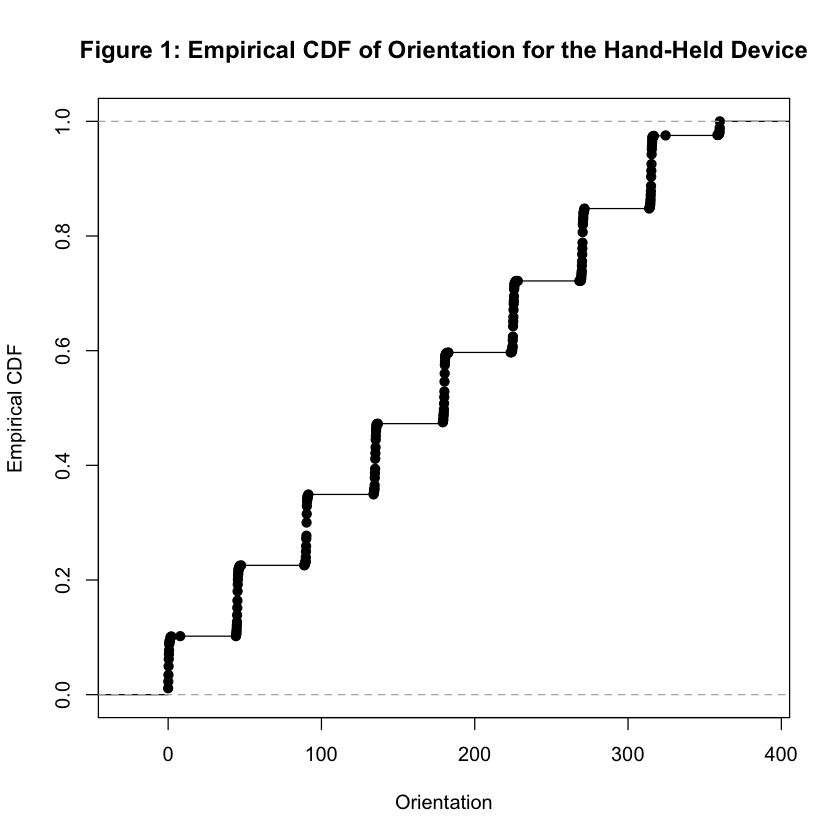

In [42]:
# Why aren't there just 8 orientations? What does the distribution actually look like?
# From the following, we can tell that we are using both 0 and 360 degrees (these should be combined)
# Also, there seems to be too much precision here, meaning it seems that we have a bunch of values like 0.12 (which should be just 0)

plot(ecdf(offline$orientation),main="Figure 1: Empirical CDF of Orientation for the Hand-Held Device",
        xlab="Orientation", ylab="Empirical CDF")

In [43]:
# Let's round the numbers down for better factoral variables
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}
             
offline$angle = roundOrientation(offline$orientation)

In [50]:
# We only expect 8 different orientations, but there appears to be actualy 203
length(unique(offline$orientation))

[1] 203

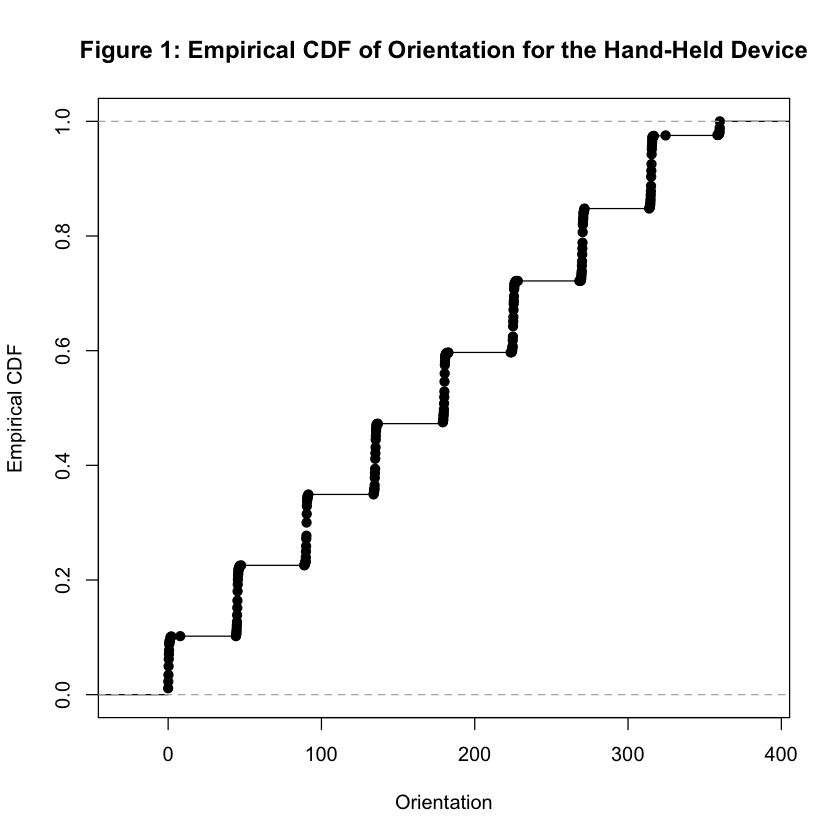

In [51]:
# Why aren't there just 8 orientations? What does the distribution actually look like?
# From the following, we can tell that we are using both 0 and 360 degrees (these should be combined)
# Also, there seems to be too much precision here, meaning it seems that we have a bunch of values like 0.12 (which should be just 0)

plot(ecdf(offline$orientation),main="Figure 1: Empirical CDF of Orientation for the Hand-Held Device",
        xlab="Orientation", ylab="Empirical CDF")

In [52]:
# Let's round the numbers down for better factoral variables
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}
             
offline$angle = roundOrientation(offline$orientation)

In [53]:
# Check out number of unique mac address and channels
c(length(unique(offline$mac)), length(unique(offline$channel)))

[1] 12  8

In [54]:
# Get a count at how many times each MAC shows up
table(offline$mac)


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

In [55]:
# There is some oddities with some of the access points - let's just take the top 7
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

In [56]:
# New count of how many times each MAC shows up
table(offline$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
           145619            145862            126529            120339 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           132962            121325            122315 

In [57]:
# Look at combination of mac/channel
macChannel = with(offline, table(mac, channel))
macChannel

                   channel
mac                 2412000000 2422000000 2427000000 2432000000 2437000000
  00:0f:a3:39:dd:cd     145619          0          0          0          0
  00:0f:a3:39:e1:c0          0          0          0          0          0
  00:14:bf:3b:c7:c6          0          0          0     126529          0
  00:14:bf:b1:97:81          0     120339          0          0          0
  00:14:bf:b1:97:8a          0          0          0          0     132962
  00:14:bf:b1:97:8d          0          0          0          0          0
  00:14:bf:b1:97:90          0          0     122315          0          0
                   channel
mac                 2442000000 2462000000
  00:0f:a3:39:dd:cd          0          0
  00:0f:a3:39:e1:c0          0     145862
  00:14:bf:3b:c7:c6          0          0
  00:14:bf:b1:97:81          0          0
  00:14:bf:b1:97:8a          0          0
  00:14:bf:b1:97:8d     121325          0
  00:14:bf:b1:97:90          0          0

In [58]:
# Let's make sure that each Mac shows up at least once in a channel
apply(macChannel, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

In [59]:
# We do not need "channel" anymore because there is at least one mac per channel?
offline = offline[ , "channel" != names(offline)]

In [60]:
locDF = with(offline,
             by(offline, list(posX, posY), function(x) x))
length(locDF)

[1] 476

In [61]:
# Check how many are empty (null)
sum(sapply(locDF, is.null))

[1] 310

In [62]:
# Drop null values
locDF = locDF[ !sapply(locDF, is.null) ]

In [63]:
length(locDF)

[1] 166

In [64]:
# If we want position with the location
locCounts = sapply(locDF,
                   function(df)
                     c(df[1, c("posX", "posY")], count = nrow(df)))

In [65]:
class(locCounts)

[1] "matrix"

In [66]:
dim(locCounts)

[1]   3 166

In [67]:
head(locCounts)

posX,0,1,2,0,1,2,0,1,2,0,⋯,2,0,1,2,0,1,2,0,1,2
posY,0,0,0,1,1,1,2,2,2,3,⋯,10,11,11,11,12,12,12,13,13,13
count,5505,5505,5506,5524,5543,5558,5503,5564,5513,5529,⋯,5557,5488,5523,5656,5524,5544,5734,5523,5553,5774


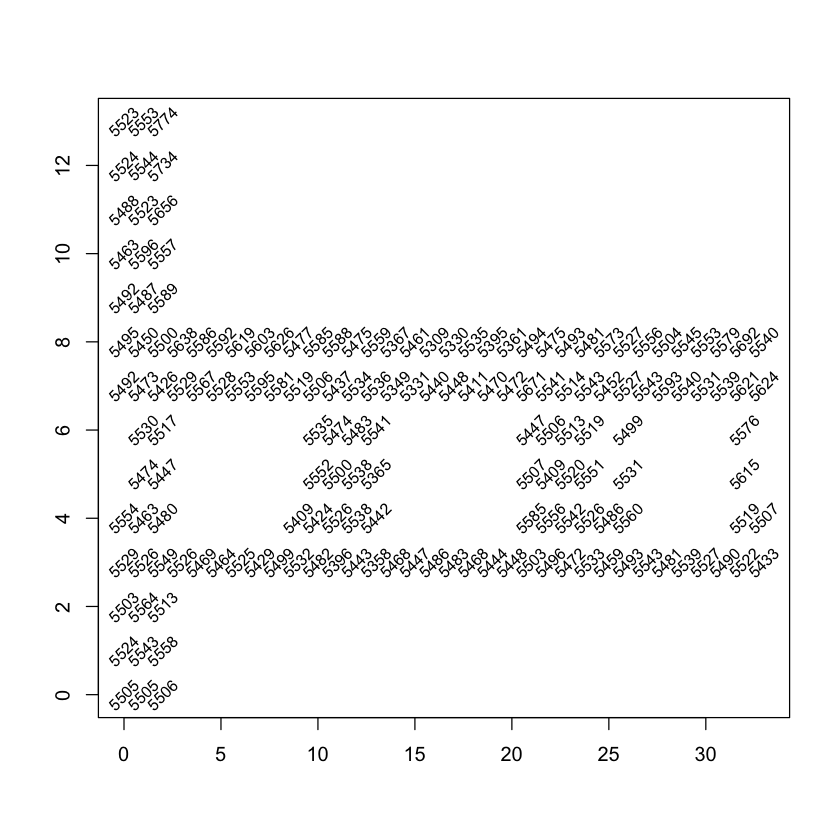

In [68]:
# Visualize the locations with their counts
locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

# Write to a csv

Now that the initial exploratory analysis and cleanup is completed, the information is written to a csv for future analysis.

In [69]:
write.csv(offline, DATA_FRAME_SOURCE)

In [70]:
sprintf('Wrote to %s', c(DATA_FRAME_SOURCE))

[1] "Wrote to ../data/offline.final.trace.csv"

In [71]:
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.139643e+12,0


In [75]:
offline = read.csv(OFFLINE_SOURCE, row.names=1)
#online = readData(ONLINE_SOURCE, subMacs = macs)


In [76]:
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.139643e+12,0


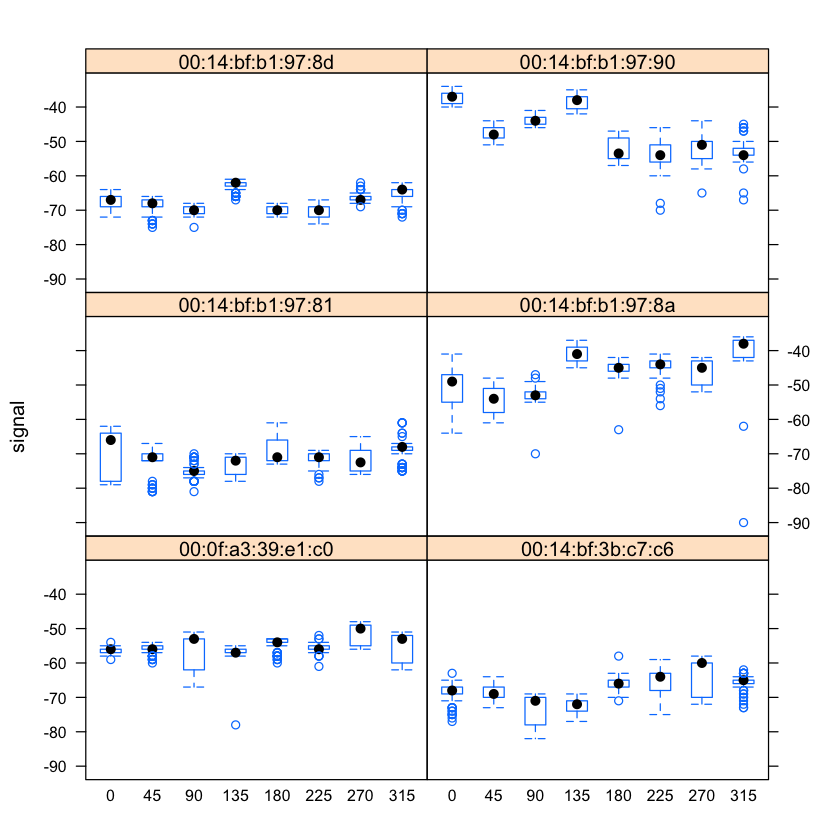

In [77]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline,
subset = posX == 2 & posY == 12
& mac != "00:0f:a3:39:dd:cd",
layout = c(2,3))

Comparing the distributions of signal strength for different angles
and MAC addresses at the central location of x = 23 and y = 4

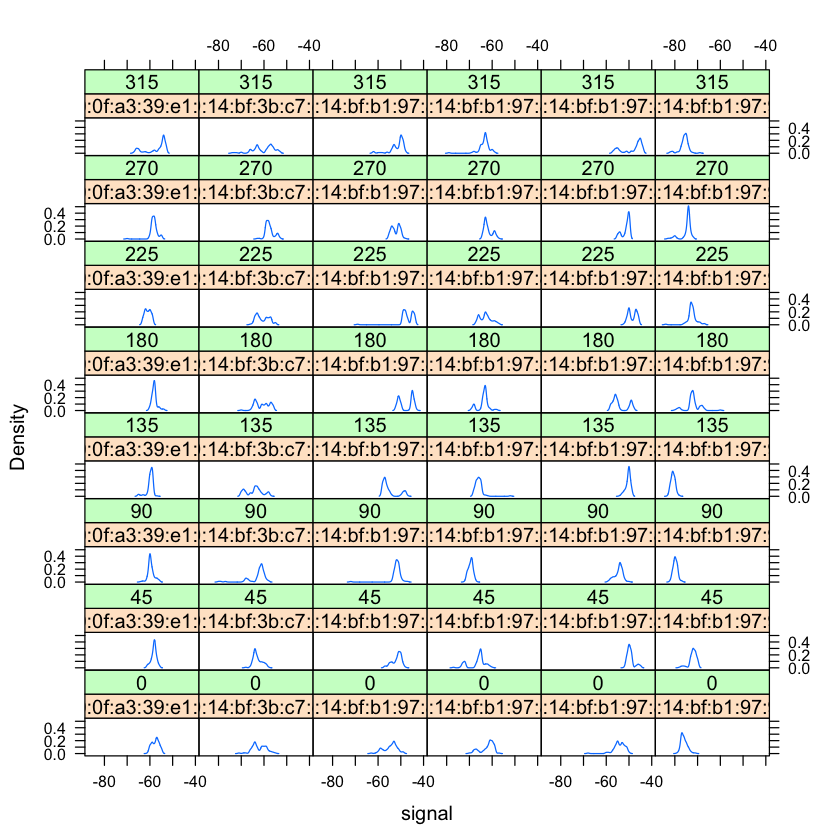

In [78]:
densityplot( ~ signal | mac + factor(angle), data = offline,
subset = posX == 24 & posY == 4 &
mac != "00:0f:a3:39:dd:cd",
bw = 0.5, plot.points = FALSE)

Examine the distribution of signal strength for all 166 locations,8 angles and 6 acess points using sumarry statitics

In [79]:
#Create a special factor that contains all of the unique combinations 
#of the observed (x, y) pairs for the 166 locations. 

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

#create a list of data frames for every combination of (x, y), angle, and access point
byLocAngleAP = with(offline,
by(offline, list(posXY, angle, mac),
function(x) x))
   
#create summary statistics on each of the data frames
   
signalSummary =
lapply(byLocAngleAP,
function(oneLoc) {
ans = oneLoc[1, ]
ans$medSignal = median(oneLoc$signal)
ans$avgSignal = mean(oneLoc$signal)
ans$num = length(oneLoc$signal)
ans$sdSignal = sd(oneLoc$signal)
ans$iqrSignal = IQR(oneLoc$signal)
ans
})
   


In [80]:
offlineSummary = do.call("rbind", signalSummary)

Examine the standard deviations and see if they vary with the average signal
strength

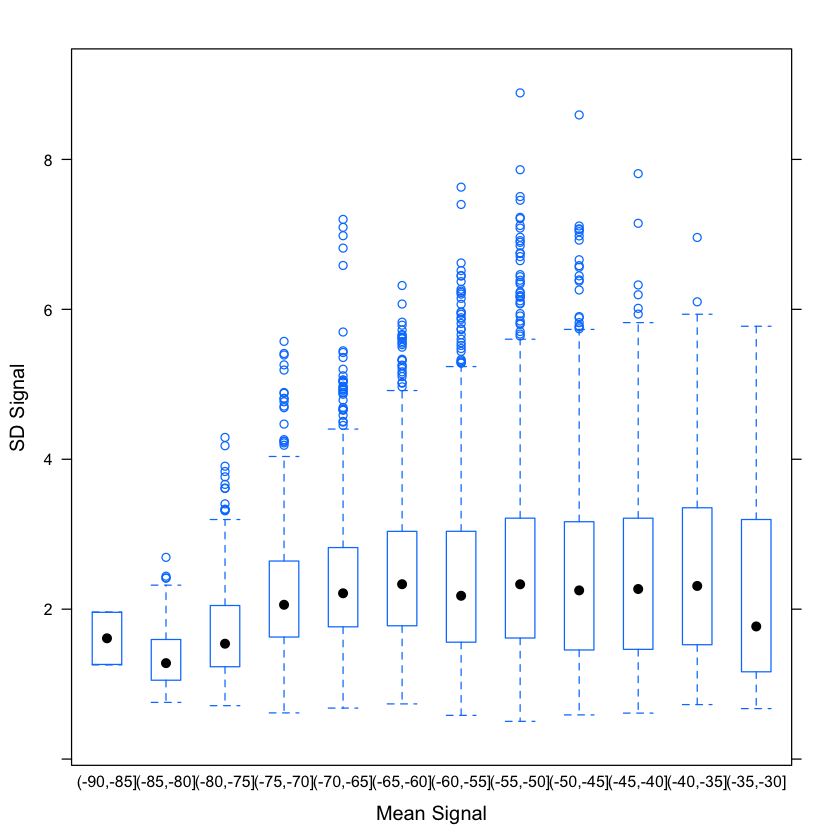

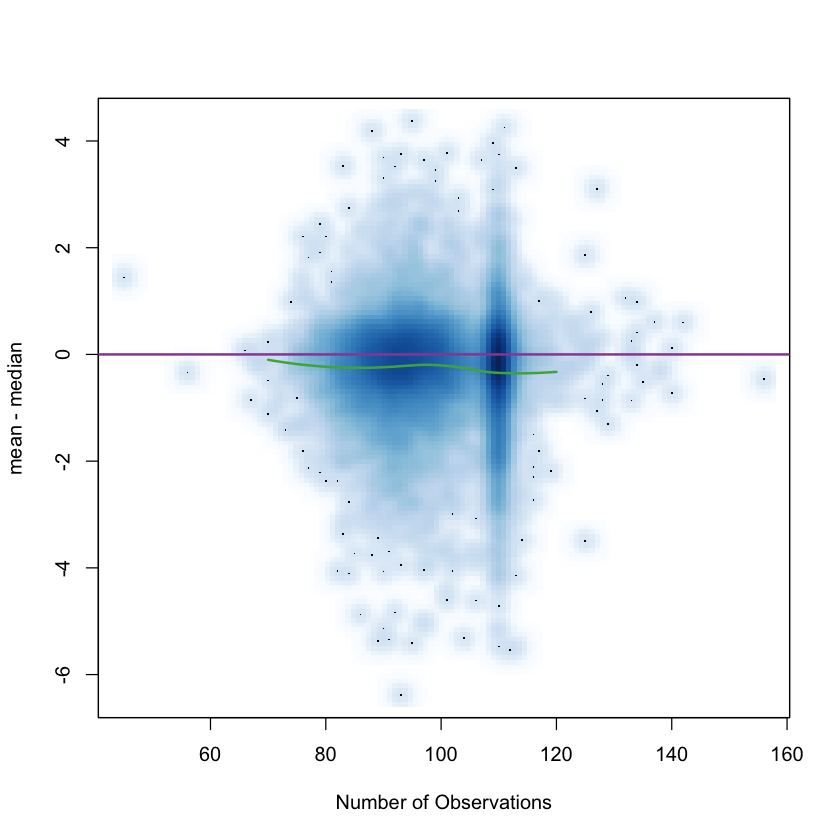

In [81]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
data = offlineSummary,
subset = mac != "00:0f:a3:39:dd:cd",
xlab = "Mean Signal", ylab = "SD Signal")

with(offlineSummary,
smoothScatter((avgSignal - medSignal) ~ num,
xlab = "Number of Observations",
ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)


lo.obj =
with(offlineSummary,
loess(diff ~ num,
data = data.frame(diff = (avgSignal - medSignal),
num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)


In [82]:
library(fields)
#get subMacs from previiys clean file 
subMacs = c('00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81')


oneAPAngle = subset(offline, mac == subMacs[5] & angle == 0)

oneAPAngle = subset(offlineSummary,
mac == subMacs[5] & angle == 0)


smoothSS = Tps(oneAPAngle[, c("posX","posY")],
oneAPAngle$avgSignal)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


In [83]:
vizSmooth = predictSurface(smoothSS)

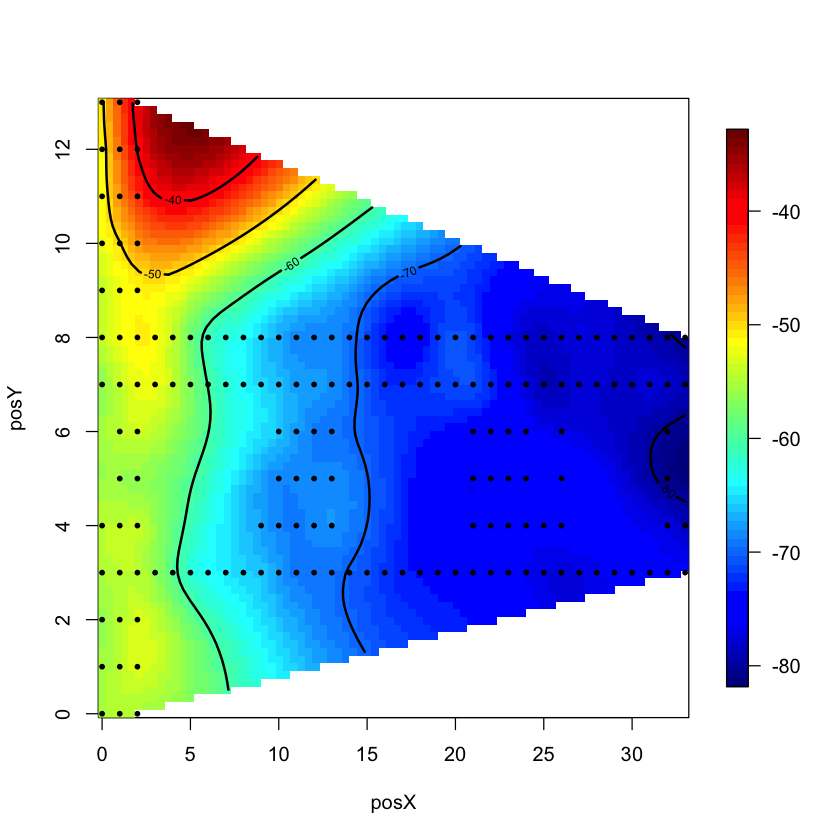

In [84]:
plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

#missing function calll to create four plots

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

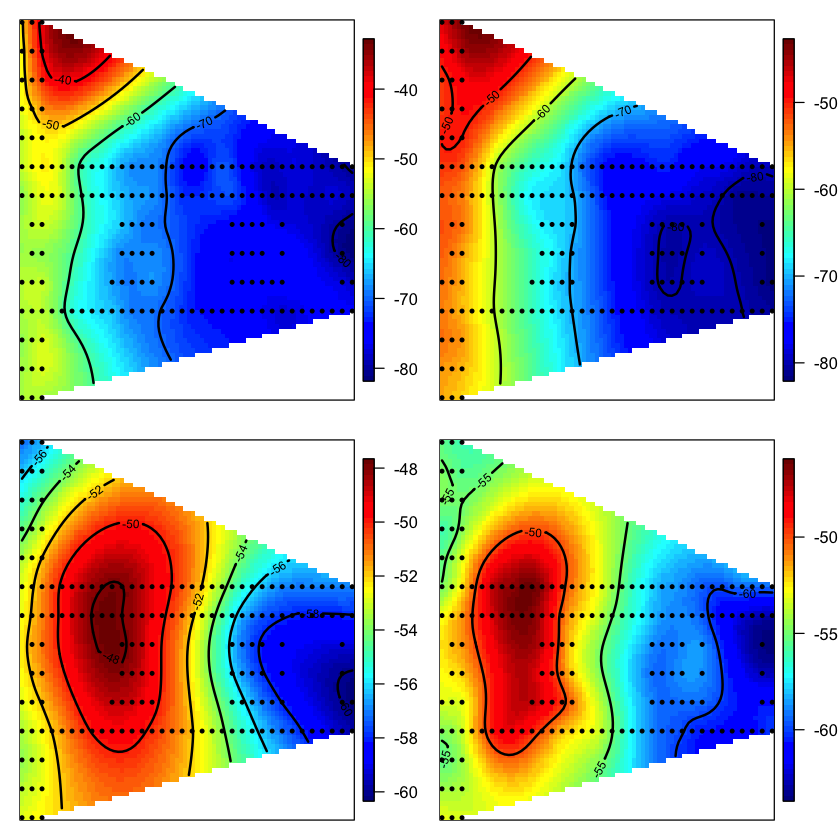

In [85]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))


mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ],
angle = rep(c(0, 135), 2),
data = list(data = offlineSummary))

In [86]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

In [87]:
# Lang and Nolan bin these angles so they become more powerful class vars
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

In [88]:
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

# Perform Analysis for KNN

In [90]:
offline = read.csv(OFFLINE_SOURCE_CSV, row.names=1)

In [94]:
online = readData(ONLINE_SOURCE)

In [91]:
#Create a special factor that contains all of the unique combinations 
#of the observed (x, y) pairs for the 166 locations. 

get.summary = function(df) {
    df$posXY = paste(df$posX, df$posY, sep = "-")

    #create a list of data frames for every combination of (x, y), angle, and access point
    byLocAngleAP = with(df,
    by(df, list(posXY, angle, mac),
    function(x) x))

    #create summary statistics on each of the data frames

    signalSummary =
        lapply(byLocAngleAP,
        function(oneLoc) {
            ans = oneLoc[1, ]
            ans$medSignal = median(oneLoc$signal)
            ans$avgSignal = mean(oneLoc$signal)
            ans$num = length(oneLoc$signal)
            ans$sdSignal = sd(oneLoc$signal)
            ans$iqrSignal = IQR(oneLoc$signal)
            return(ans)
        })
    return(do.call("rbind", signalSummary))
}

In [92]:
offlineSummary = get.summary(offline)

In [95]:
online$posXY = paste(online$posX, online$posY, sep = "-")
tabonlineXYA = table(online$posXY, online$angle)

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online,
             by(online, list(posXY),
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6)
                  cbind(ans, y)
                }))
onlineSummary = do.call("rbind", byLoc)

Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data length [7] is not a sub-multiple or multiple of the number of columns [6]”Warning message in matrix(avgSS, nrow = 1, ncol = 6):
“data le

In [97]:
selectTrain = function (angleNewObs, signals, m, macs=ALL_MACS) {
    refs = seq(0, by = 45, length  = 8)
    nearestAngle = roundOrientation(angleNewObs)
    if (m %% 2 == 1) {
      angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    } else {
        m=m+1
        angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
        if (sign(angleNewObs - nearestAngle) > -1)
            angles = angles[ -1 ]
        else
            angles = angles[ -m ]
    }
    
    angles = angles + nearestAngle
    angles[angles < 0] = angles[ angles < 0 ] + 360
    angles[angles > 360] = angles[ angles > 360 ] - 360
    offlineSubset = signals[ signals$angle %in% angles, ]

    reshapeSS = function(data, varSignal = "signal",
                     keepVars = c("posXY", "posX","posY")) {
        
        byLocation =
            with(data, by(data, list(posXY),
                          function(x) {
                            ans = x[1, keepVars]
                            avgSS = tapply(x[ , varSignal ], x$mac, mean)
                            avgSS = avgSS[macs]
                            y = matrix(avgSS, nrow = 1, dimnames=list(ans$posXY, names(avgSS)))
        cbind(ans, y)
            }))
          newDataSS = do.call("rbind", byLocation)
      return(newDataSS)
    }


    # TODO: I'm getting a bunch of warnings about columns length not matching
    return(suppressWarnings(reshapeSS(offlineSubset, varSignal = "avgSignal")))
}

In [103]:
select.last.n.columns.from.df = function (df, n) {
    df[,(ncol(df)-n+1):ncol(df)]
}

In [98]:
findNN = function(newSignal, trainSubset, macs) {
    mac.columns = select.last.n.columns.from.df(trainSubset, length(macs))
  diffs = apply(mac.columns, 1,
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [99]:
predXY = function(newSignals, newAngles, trainData,
                  numAngles = 1, k = 3, macs = ALL_MACS){
    print(macs)
    print(dim(trainData))
  closeXY = list(length = nrow(newSignals))
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles, macs)
    closeXY[[i]] =
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS, macs)
  }
  estXY = lapply(closeXY,
                 function(x) sapply(x[ , 2:3],
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [100]:
calcError = function(estXY, actualXY)
   sum( rowSums( (estXY - actualXY)^2) )

# The real analysis


In [106]:
actualXY = onlineSummary[ , c("posX", "posY")]

In [104]:
getErrorFromMac = function (macs) {
    offline2 = readData(OFFLINE_SOURCE, macs)
    offlineSummary2 = get.summary(offline2)
    signals = select.last.n.columns.from.df(onlineSummary, length(macs))
    kyPrediction.original.macs = predXY(newSignals = signals,
                     newAngles = onlineSummary[ , 4],
                     offlineSummary2, numAngles = 3, k = 3, macs)
    calcError(kyPrediction.original.macs, actualXY)
}

### Using MACs from the book

In [107]:
getErrorFromMac(ORIGINAL_MACS)

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[1] 7968   14


[1] 20561.03

### Using different MACs

In [108]:
getErrorFromMac(NEXT_MACS)

[1] "00:0f:a3:39:dd:cd" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[1] 7968   14


[1] 17582.9

### All MACS

In [109]:
getErrorFromMac(ALL_MACS)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"
[1] 9296   14


[1] 8722.523